In [1]:
import os, sys, numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from agents.bandits.gaussianprocess import IGPUCB

from environments.toy import NoiseEnv

Current path: /Users/marcomussi/git/PricingComplementaryProducts


In [2]:
class Runner: 

    
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    
    def run_simulations(self, horizon, n_runs, draw_intermediate=False, draw_every=1): 
        
        pseudo_regret_all = np.zeros((n_runs, horizon))
        regret_all = np.zeros((n_runs, horizon))
        horizon_plt = np.linspace(1, horizon, horizon, dtype=int)

        for run_i in range(n_runs):
            
            self.agent.reset()
            self.env.reset(seed=run_i)
            
            if draw_intermediate:
                plt.figure()
                plt_count = 0
                cols = 4
                rows = int(horizon/draw_every/cols) + 1
                n_plt = 50
                x_plt = np.linspace(0, 1, n_plt).reshape(n_plt, 1)
                f, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
            
            actions = np.zeros((horizon, self.agent.action_dim))
            actions_idx = np.zeros(horizon, dtype=int)
            rewards = np.zeros(horizon)
            
            for t in tqdm(range(horizon)):
                
                actions[t, :] = self.agent.pull()
                actions_idx[t] = np.where((self.env.actions == actions[t, :]).all(axis=1))[0][0]
                rewards[t] = self.env.step(actions[t, :])
                self.agent.update(rewards[t])
                
                if draw_intermediate and t % draw_every == 0:
                    mu, sigma = self.agent.regressor.compute(x_plt)
                    ax[int(plt_count/cols), plt_count%cols].plot(x_plt.ravel(), mu, label="GP Estimate")
                    ax[int(plt_count/cols), plt_count%cols].fill_between(x_plt.ravel(), mu-sigma, mu+sigma, alpha=0.3)
                    ax[int(plt_count/cols), plt_count%cols].scatter(self.env.actions, self.env.values, label="Real Function")
                    ax[int(plt_count/cols), plt_count%cols].set_title(f"t = {t+1}")
                    ax[int(plt_count/cols), plt_count%cols].scatter(actions[:t+1], rewards[:t+1], label="Samples")
                    ax[int(plt_count/cols), plt_count%cols].set_xlim([0, 1])
                    ax[int(plt_count/cols), plt_count%cols].set_ylim([-1, 2])
                    for act in np.unique(actions[:t+1]):
                        avg = rewards[:t+1]
                        mask = actions[:t+1] == act
                        avg = np.mean(avg[mask.ravel()])
                        ax[int(plt_count/cols), plt_count%cols].scatter(act, avg, label="Avg Samples")  
                    plt_count += 1

            plt.figure()
            regret = np.cumsum(np.max(self.env.values) - rewards)
            pseudo_regret = np.cumsum(np.max(self.env.values) - self.env.values[actions_idx])
            regret_all[run_i, :] = regret
            pseudo_regret_all[run_i, :] = pseudo_regret
            plt.plot(horizon_plt, regret, label="Cumulative Regret")
            plt.plot(horizon_plt, pseudo_regret, label="Cumulative Pseudo-Regret")
            plt.legend()
        
        plt.figure()
        plt.plot(horizon_plt, np.mean(regret_all, axis=0), label="Average Cumulative Regret")
        plt.fill_between(horizon_plt, np.mean(regret_all, axis=0) - np.std(regret_all, axis=0), np.mean(regret_all, axis=0) + np.std(regret_all, axis=0), alpha=0.3)
        plt.plot(horizon_plt, np.mean(pseudo_regret_all, axis=0), label="Average Cumulative Pseudo-Regret")
        plt.fill_between(horizon_plt, np.mean(pseudo_regret_all, axis=0) - np.std(pseudo_regret_all, axis=0), np.mean(pseudo_regret_all, axis=0) + np.std(pseudo_regret_all, axis=0), alpha=0.3)
        plt.legend()
        

Bernoulli Noise Environment


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

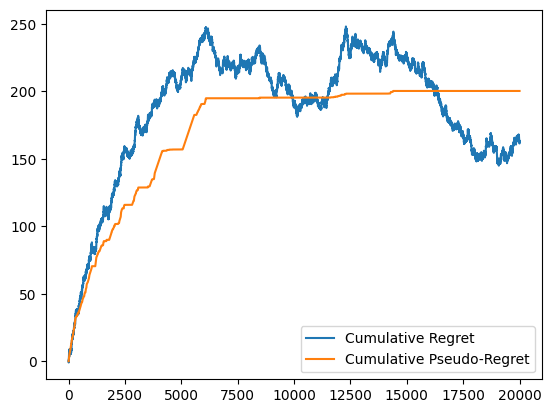

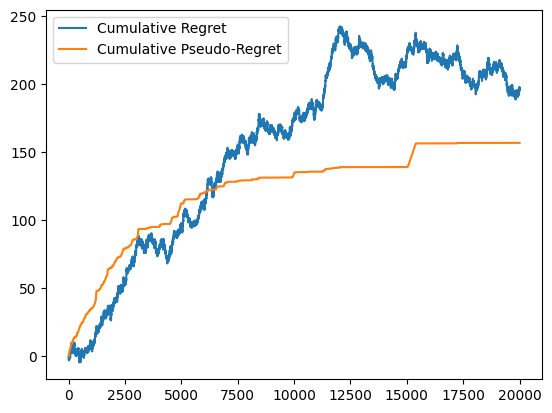

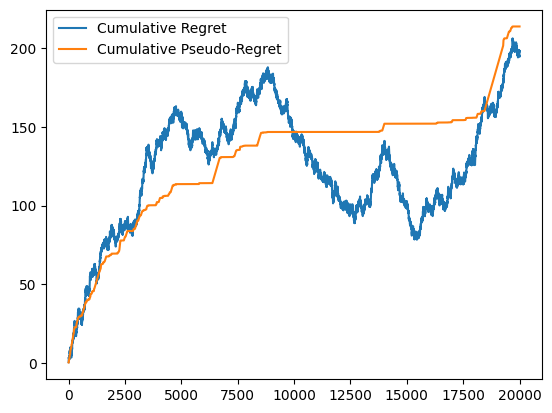

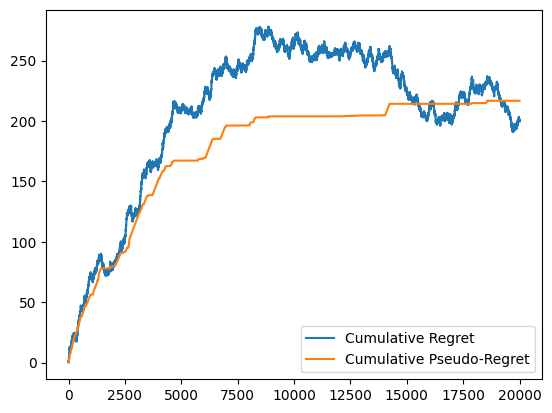

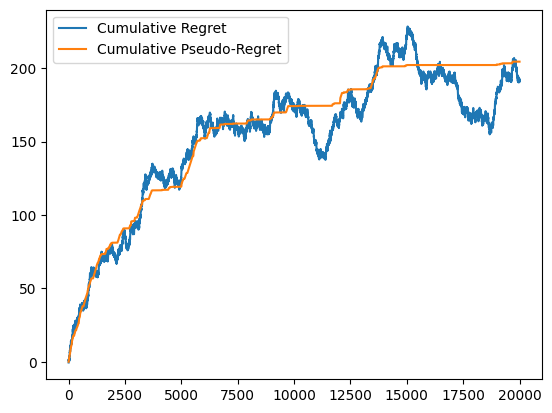

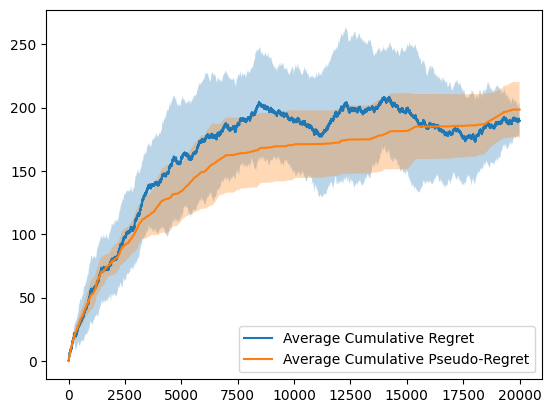

In [3]:
horizon = 20000
kernel_L = 100
sigma_sq = 0.25
bernoulli = True
n_actions = 6

n_runs = 5
draw_intermediate = False
draw_every = 50

if bernoulli:
    print("Bernoulli Noise Environment")
    sigma_sq = 0.25 # overwritten as it is fixed for Bernoulli noise
else:
    print("Gaussian Noise Environment")

B = 1
delta = 1 / horizon

actions = np.linspace(0, 1, n_actions).reshape(-1, 1)
values = np.array([0.2, 0.3, 0.5, 0.55, 0.4, 0.5])

agent = IGPUCB(n_actions, 1, actions, kernel_L, sigma_sq, B, delta, het=True)
env = NoiseEnv(actions, values, sigma_sq, bernoulli=bernoulli)
runner = Runner(agent, env)
runner.run_simulations(horizon=horizon, n_runs=n_runs, draw_intermediate=draw_intermediate, draw_every=draw_every)